## Comparing Demographic Trends in Australian Census Data (2021 and 2016)

**Date:** August 2025.

## 1. Question 

How did housing tenure and dwelling structure in Australia change between the 2016 and 2021 Census, and how did the distribution of persons across dwelling types and the average persons per occupied private dwelling (PPD) shift? What do these combined changes imply about affordability and urbanisation?

**Relevant tables:**  
- **2016:**  
  - `G32 Dwelling Structure`  
  - `G33 Tenure and Landlord Type by Dwelling Structure`  
- **2021:**  
  - `G36 Dwelling Structure`  
  - `G37 Tenure and Landlord Type by Dwelling Structure`

## 2. Setup

Before running the functions and codes, first we need to prepare the kernel by importing necessary functions.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Now we assign our paths to variables for easier access.

In [2]:
# Dwelling structure 2016
path_2016_G32 = "/kaggle/input/australian-census-dataset/2016Census_G32_AUS.csv"
 # Tenure & landlord 2016
path_2016_G33 = "/kaggle/input/australian-census-dataset/2016Census_G33_AUS.csv"
# Dwelling structure 2021
path_2021_G36 = "/kaggle/input/australian-census-dataset/2021Census_G36_AUS_AUS.csv"
# Tenure & landlord 2021
path_2021_G37 = "/kaggle/input/australian-census-dataset/2021Census_G37_AUS_AUS.csv"

## 3. Helper Functions

This section is all the functions that make the rest of the notebook smoother. They don’t do analysis by themselves, but they keep the data clean, consistent, and easy to plot/compare.

### Loading & Basic Cleaning

`load_table(...)`

* **What it does:** Reads a CSV file into a pandas dataframe.
* **Why:** All tables come as CSVs inside the DataPack. This gives us a safe way to load them.

`safe_num(...)`

* **What it does:** Converts any input to a float; returns **0.0** if parsing fails or the value is missing (`NaN`).
* **why:** After visual inspection, I noticed these tables sometimes contain, “..”, or weird strings in numeric fields.
 
### Consistent Category Ordering

`DWELL_ORDER` and `TENURE_ORDER`

* **What they are:** Fixed lists that define the order of categories (e.g., “Separate house” before “Apartment / unit”, “Owned outright” before “Rented”).
* **Why:** Without this, pandas/matplotlib can change category order between cells/joins, which makes charts jump around and comparisons harder to read.

### Extracting clean tables from raw data

`extract_dwelling_structure_and_persons(...)`

* **What it does:** pulls **one row** of key fields from the raw G32/G36 sheet and turns it into a **clean table** with columns:

  * `DwellingType`, `Dwellings`, `Persons`
  * derived shares: `DwellProp`, `PersonProp`
  * intensity: `PPD` (persons per dwelling)
  * totals: `TotalDwellings`, `TotalPersons`
* **How:** It maps the unreadable ABS column names (e.g., `OPDs_Flt_apart_Tot_Dwgs`) to simple labels, uses `safe_num(...)` to read values safely, and computes:

  * `DwellProp` = dwellings / total dwellings (per year)
  * `PersonProp` = persons / total persons (per year)
  * `PPD` = persons / dwellings (guarded against divide-by-zero)
* **Extras:** Applies `DWELL_ORDER` so plots are consistently ordered.
* **Why:** This is the backbone for structure-level analysis (supply of dwellings vs people, person-share, PPD, etc.).

`extract_tenure(...)`

* **What it does:** Pulls tenure counts from G33/G37 and returns a tidy **`Tenure` + `Count`** table, plus a **`Proportion`** column.
* **How:** Reads “owned outright”, “owned with mortgage”, “rented”, and merges “other” + “not stated”, then divides by the `Total` to get proportions.
* **Why:** Makes tenure comparison dead simple: I can join 2016/2021, then plot shares and percentage-point changes without wrestling raw codes.

### small but useful math + joins

`proportions(...)`

* **What it does:** Adds a `Proportion` column = `Count / total` within the frame.
* **Why:** It **shares** across years (population changed), then convert to percentage points for year-over-year comparisons.

`left_join_categories(...)`

* **What it does:** Aligns labels between years by joining on a category key (e.g., `DwellingType` or `Tenure`), and renames columns to:

  * 2016 → `Count2016`, `Prop2016`
  * 2021 → `Count2021`, `Prop2021`
* **Why:** ABS sometimes drops/renames categories between years. a left/outer join keeps everything aligned and makes deltas trivial to compute.

### Neat labels for charts

`annotate_bars(ax, rects, fmt="{:.1f}", va="bottom", ypad=0.5)`

* **What it does:** Writes the numeric value on top of each bar.
* **Why:** It saves readers from guessing or squinting at axes—great for side-by-side comparisons (2016 vs 2021) where exact values matter.

In [3]:
# read paths to pandas dataframes
def load_table(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    df = pd.read_csv(path)
    return df

# convert any value to float; return 0.0 if parsing fails/NaN.
def safe_num(x):
    try:
        v = pd.to_numeric(x)
        if pd.isna(v): # if variable is not available
            return 0.0
        return float(v)
    except Exception:
        return 0.0

# category order for consistent display
DWELL_ORDER = [
    "Separate house",
    "Semi-detached / townhouse",
    "Apartment / unit",
    "Other dwelling",
    "Not stated",
]
TENURE_ORDER = [
    "Owned outright",
    "Owned with mortgage",
    "Rented",
    "Other / not stated",
]

# build dwelling table from G33/G37.
def extract_dwelling_structure_and_persons(df):
    row = df.iloc[0]

    # Column keys for Dwellings
    c_sep_dw   = "OPDs_Separate_house_Dwellings" # Occupied_private_dwellings_Separate_house_Dwellings
    c_sd_dw    = "OPDs_SD_r_t_h_th_Tot_Dwgs" # Occupied_private_dwellings_Semi_detached_row_or_terrace_house_townhouse_etc_with_Total_Dwellings
    c_apt_dw   = "OPDs_Flt_apart_Tot_Dwgs" # Occupied_private_dwellings_Flat_or_apartment_Total_Dwellings
    c_other_dw = "OPDs_Other_dwelling_Tot_Dwgs" # Occupied_private_dwellings_Other_dwelling_Total_Dwellings
    c_ns_dw    = "OPDs_Dwlling_structur_NS_Dwgs" # Occupied_private_dwellings_Dwelling_structure_not_stated_Dwellings
    c_total_dw = "OPDs_Tot_OPDs_Dwellings" # Occupied_private_dwellings_Total_occupied_private_dwellings_Dwellings

    # Column keys for Persons
    c_sep_ps   = "OPDs_Separate_house_Persons" # Occupied_private_dwellings_Separate_house_Persons
    c_sd_ps    = "OPDs_SD_r_t_h_th_Tot_Psns" # Occupied_private_dwellings_Semi_detached_row_or_terrace_house_townhouse_etc_with_Total_Persons
    c_apt_ps   = "OPDs_Flt_apart_Tot_Psns" # Occupied_private_dwellings_Flat_or_apartment_Total_Persons
    c_other_ps = "OPDs_Other_dwelling_Tot_Psns" # Occupied_private_dwellings_Other_dwelling_Total_Persons
    c_ns_ps    = "OPDs_Dwlling_structur_NS_Psns" # Occupied_private_dwellings_Dwelling_structure_not_stated_Persons
    c_total_ps = "OPDs_Tot_OPDs_Persons" # Occupied_private_dwellings_Total_occupied_private_dwellings_Persons

    # Pull values safely
    sep_dw,   sep_ps   = safe_num(row.get(c_sep_dw, 0)),   safe_num(row.get(c_sep_ps, 0))
    sd_dw,    sd_ps    = safe_num(row.get(c_sd_dw, 0)),    safe_num(row.get(c_sd_ps, 0))
    apt_dw,   apt_ps   = safe_num(row.get(c_apt_dw, 0)),   safe_num(row.get(c_apt_ps, 0))
    other_dw, other_ps = safe_num(row.get(c_other_dw, 0)), safe_num(row.get(c_other_ps, 0))
    ns_dw,    ns_ps    = safe_num(row.get(c_ns_dw, 0)),    safe_num(row.get(c_ns_ps, 0))

    tot_dw = safe_num(row.get(c_total_dw, 0))
    tot_ps = safe_num(row.get(c_total_ps, 0))

    # Build tidy
    data = [
        ("Separate house",             sep_dw,   sep_ps),
        ("Semi-detached / townhouse",  sd_dw,    sd_ps),
        ("Apartment / unit",           apt_dw,   apt_ps),
        ("Other dwelling",             other_dw, other_ps),
        ("Not stated",                 ns_dw,    ns_ps),
    ]
    out = pd.DataFrame(data, columns=["DwellingType", "Dwellings", "Persons"])

    out["DwellProp"]  = 0.0 if tot_dw == 0 else out["Dwellings"] / tot_dw # Dwellings Proportion
    out["PersonProp"] = 0.0 if tot_ps == 0 else out["Persons"]   / tot_ps # Persons Proportion
    out["PPD"]        = 0.0 # Persons Per Dwelling
    mask = out["Dwellings"] > 0
    out.loc[mask, "PPD"] = out.loc[mask, "Persons"] / out.loc[mask, "Dwellings"]

    out["TotalDwellings"] = tot_dw
    out["TotalPersons"]   = tot_ps

    # Sort consistently
    out["DwellingType"] = pd.Categorical(out["DwellingType"], categories=DWELL_ORDER, ordered=True)
    out = out.sort_values("DwellingType").reset_index(drop=True)
    return out

# build tenure table from G33/G37.
def extract_tenure(df):
    row = df.iloc[0]

    c_outright = "O_OR_Total" # Owned_outright_Total
    c_mortg    = "O_MTG_Total" # Owned_with_a_mortgage_Total
    c_rented   = "R_Tot_Total" # Rented_Total_Total
    c_other    = "Oth_ten_type_Total" # Other_tenure_type_Total
    c_ns       = "Ten_type_NS_Total" # Tenure_type_not_stated_Total
    c_total    = "Total_Total" # Total_Total

    owned_outright      = safe_num(row.get(c_outright, 0))
    owned_with_mortgage = safe_num(row.get(c_mortg,    0))
    rented              = safe_num(row.get(c_rented,   0))
    other_notstated     = safe_num(row.get(c_other,    0)) + safe_num(row.get(c_ns, 0))

    data = [
      ("Owned outright",        owned_outright),
      ("Owned with mortgage",   owned_with_mortgage),
      ("Rented",                rented),
      ("Other / not stated",    other_notstated),
    ]
    out = pd.DataFrame(data, columns=["Tenure", "Count"])
    denom = safe_num(row.get(c_total, 0))
    out["Proportion"] = out["Count"] / denom if denom else 0.0 # divide the values under count column by the total to get proportion
    return out

# function to calculate proportions
def proportions(df, group_col, count_col):
    total = df[count_col].sum()
    df["Proportion"] = 0.0 if total == 0 else df[count_col] / total
    return df

# merge two year tables on a categorical key to align labels.
def left_join_categories(df2016, df2021, key):
    x = df2016.rename(columns={"Count":"Count2016","Proportion":"Prop2016"})
    y = df2021.rename(columns={"Count":"Count2021","Proportion":"Prop2021"})
    return pd.merge(x, y, on=key, how="outer")

## 4. Loading the Census Tables

Before we can do any analysis, first we need to **load the raw Census tables** (G32/G36 and G33/G37) and convert them into a **clean format** that’s easier to work with. This stage is about:

1. Reading the raw date.
2. Extracting what we need (tenure or dwelling structure + persons).
3. Adding a `Year` column so we can identify the rows and join 2016 and 2021 later.
4. Calculating proportions where it makes sense, so we’re not only looking at raw counts.



### Functions used

`load_tenure_table(...)`

* **What it does:** loads a **tenure table** (G33 for 2016, G37 for 2021).
* **Steps:**

  1. Calls `load_table(path)` to read the CSV.
  2. Passes that to `extract_tenure(df)` which filters/reshapes just the tenure data.
  3. Adds a `Year` column (so we know whether the rows are from 2016 or 2021).
  4. Calls `proportions(...)` so we get both **counts** and **shares (%)** for each tenure type.
* **What we get back:** a clean DataFrame with columns like `Tenure`, `Count`, `Proportion`, `Year`.


`load_dwelling_and_persons_table(...)`

* **What it does:** loads a **dwelling + persons table** (G32 for 2016, G36 for 2021).
* **Steps:**

  1. Reads the CSV with `load_table(path)`.
  2. Extracts the columns for dwelling structure and persons with `extract_dwelling_structure_and_persons(df)`.
  3. Adds a `Year` column.
* **What I get back:** a clean DataFrame with columns like `DwellingType`, `Dwellings`, `Persons`, `Year`.

This table is the one we’ll later use to calculate persons-per-dwelling (PPD) and compare dwellings vs people.



#### Why we used `try/except`?

Each load is in `try/except` so if something goes wrong, the notebook prints the error instead of breaking everything. That way we can debug without crashing the whole run.



#### What we check right after?

At the end we do a `display(...)` of `.head()` for each table. This is just a **sanity check**:

* If the table loaded correctly, we’ll see the first few rows.
* If not, we’ll see `(empty)` so we know we need to go back and check paths or extraction.



This stage is all about **getting the right data into the right shape**. Once we have these tidy tables for 2016 and 2021, the rest of the pipeline (visualisations and summaries) can build on top of them smoothly.

In [4]:
# Load G33/G37 and return tidy Tenure counts + proportions.
def load_tenure_table(path, year_label):
    df = load_table(path)
    tn = extract_tenure(df)
    tn["Year"] = year_label
    tn = proportions(tn, group_col="Tenure", count_col="Count")
    return tn

# Load G32/G36 and return tidy Dwelling Type and Persons counts + proportions.
def load_dwelling_and_persons_table(path, year_label):
    df = load_table(path)
    tidy = extract_dwelling_structure_and_persons(df)
    tidy["Year"] = year_label
    return tidy

try:
    tenure_2016 = load_tenure_table(path_2016_G33, 2016)
except Exception as e:
    print(e)

try:
    tenure_2021 = load_tenure_table(path_2021_G37, 2021)
except Exception as e:
    print(e)

try:
    dwellings_and_persons_2016 = load_dwelling_and_persons_table(path_2016_G32, 2016)
except Exception as e:
    print(e)

try:
    dwellings_and_persons_2021 = load_dwelling_and_persons_table(path_2021_G36, 2021)
except Exception as e:
    print(e)   

display(tenure_2016.head() if not tenure_2016.empty else "tenure_2016: (empty)")
display(tenure_2021.head() if not tenure_2021.empty else "tenure_2021: (empty)")
display(dwellings_and_persons_2016.head() if not dwellings_and_persons_2016.empty else "tidy2016: (empty)")
display(dwellings_and_persons_2021.head() if not dwellings_and_persons_2021.empty else "tidy2021: (empty)")

,Tenure,Count,Proportion,Year
0,Owned outright,2565695.0,0.309639,2016
1,Owned with mortgage,2855222.0,0.344580,2016
2,Rented,2561302.0,0.309109,2016
3,Other / not stated,303863.0,0.036671,2016


,Tenure,Count,Proportion,Year
0,Owned outright,2872331.0,0.309678,2021
1,Owned with mortgage,3242449.0,0.349582,2021
2,Rented,2842378.0,0.306449,2021
3,Other / not stated,318056.0,0.034291,2021


,DwellingType,Dwellings,Persons,DwellProp,PersonProp,PPD,TotalDwellings,TotalPersons,Year
0,Separate house,6041788.0,16877820.0,0.729149,0.785018,2.793514,8286077.0,21499917.0,2016
1,Semi-detached / townhouse,1055015.0,2306043.0,0.127324,0.107258,2.185792,8286077.0,21499917.0,2016
2,Apartment / unit,1087445.0,2114418.0,0.131238,0.098345,1.944391,8286077.0,21499917.0,2016
3,Other dwelling,64422.0,121150.0,0.007775,0.005635,1.880569,8286077.0,21499917.0,2016
4,Not stated,37410.0,80491.0,0.004515,0.003744,2.151590,8286077.0,21499917.0,2016


,DwellingType,Dwellings,Persons,DwellProp,PersonProp,PPD,TotalDwellings,TotalPersons,Year
0,Separate house,6710582.0,18507375.0,0.723496,0.785283,2.757939,9275217.0,23567772.0,2021
1,Semi-detached / townhouse,1168860.0,2468143.0,0.126020,0.104725,2.111581,9275217.0,23567772.0,2021
2,Apartment / unit,1319095.0,2453120.0,0.142217,0.104088,1.859699,9275217.0,23567772.0,2021
3,Other dwelling,54711.0,95640.0,0.005899,0.004058,1.748095,9275217.0,23567772.0,2021
4,Not stated,21970.0,43493.0,0.002369,0.001845,1.979654,9275217.0,23567772.0,2021


## 5. Visualisation & Comparison

This stage is where we **turn cleaned data into answers**. We’ve already prepared tidy tables from the 2016 and 2021 Census. Now we want to:

1. Compare **shares** (what % each category represents) across years.
2. Show **how much those shares changed** (in percentage points).
3. Connect **dwellings**, **people**, and **persons-per-dwelling (PPD)** to understand crowding/occupancy patterns by dwelling type.

In short: these helpers make it easy to see “2016 vs 2021” side-by-side, and then quantify the change.

> Quick glossary used in comments and labels:
>
> * **Share (%)** = a category’s proportion within a year (0–1 turned into %).
> * **Δ pp (percentage points)** = 2021 share − 2016 share (e.g., 40% → 45% = **+5 pp**).
> * **PPD** = persons per occupied dwelling (intensity of use).

### A) Chart helpers

`annotate_bars(...)`

* **What it does:** Writes the numeric value on top of each bar.
* **Why:** It saves readers from guessing or squinting at axes—great for side-by-side comparisons (2016 vs 2021) where exact values matter.
* **Details:** Centers the text over each bar, formats numbers (default 1 decimal), and nudges the label slightly above the bar height.

`plot_grouped_share(...)`

* **What it does:** draws **side-by-side bars** for 2016 vs 2021 so we can quickly compare shares for each category (e.g., tenure types or dwelling structures).
* **How it works:** Takes a merged table that already has `Prop2016` and `Prop2021` (as proportions 0–1), converts them to %, and plots them with tidy labels/legend. It also annotates values on the bars so we don’t have to eyeball them.
* **When we use it:** Any time we want a clean “then vs now” snapshot of **who grew/shrank** in share terms.

`plot_delta_bars(...)`

* **What it does:** shows **only the change** (2021 − 2016) in **percentage points**. Bars above zero grew; below zero shrank.
* **How it works:** expects a `Delta_pp` column and draws one bar per category, centered on 0, with the signed change printed on each bar.
* **When we use it:** right after a grouped-share plot to answer “By how much did it change?”

In [5]:
# label bars with values.
def annotate_bars(ax, rects, fmt="{:.1f}", va="bottom", ypad=0.5):
    # go through each bar and put a text label on it
    for bar in rects:
        # get how tall the bar is
        height = bar.get_height()

        # find the middle of the bar on the x-axis
        x_left = bar.get_x()
        bar_width = bar.get_width()
        x_center = x_left + (bar_width / 2.0)

        # try to format the number. if it fails, turn it into a string
        try:
            label_text = fmt.format(height)
        except Exception:
            label_text = str(height)

        # add the label slightly above the top of the bar
        ax.annotate(
            label_text,
            xy=(x_center, height),          # point to place the label at
            xytext=(0, ypad),               # small offset so it doesn't touch the bar
            textcoords="offset points",
            ha="center",                    # center the text horizontally
            va=va,                          # vertical alignment
            fontsize=9
        )

    # function doesn't need to return anything
    return None

def plot_grouped_share(df_merge, cat_col, p2016_col="Prop2016", p2021_col="Prop2021",
                       title="", ylabel="Share of total (%)", rotate=15):
    """Grouped bars comparing 2016 vs 2021 shares (in %)."""
    cats  = df_merge[cat_col].astype(str).tolist()
    vals16 = (df_merge[p2016_col] * 100.0).values
    vals21 = (df_merge[p2021_col] * 100.0).values
    x = np.arange(len(cats))
    width = 0.38
    fig, ax = plt.subplots(figsize=(10, 5.75))
    r16 = ax.bar(x - width/2, vals16, width=width, label="2016")
    r21 = ax.bar(x + width/2, vals21, width=width, label="2021")
    ax.set_xticks(x, cats, rotation=rotate, ha="right")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    annotate_bars(ax, r16); annotate_bars(ax, r21)
    ax.set_ylim(0, max(vals16.max() if len(vals16) else 0, vals21.max() if len(vals21) else 0) * 1.15 + 1)
    fig.tight_layout(); plt.show()

def plot_delta_bars(df_merge, cat_col, delta_col="Delta_pp",
                    title="Change (2016 → 2021), percentage points", rotate=15):
    """Bars of percentage-point changes (2021 - 2016)."""
    cats = df_merge[cat_col].astype(str).tolist()
    deltas = df_merge[delta_col].values
    x = np.arange(len(cats))
    fig, ax = plt.subplots(figsize=(10, 5.25))
    rects = ax.bar(x, deltas, width=0.6)
    ax.axhline(0, linewidth=1)
    ax.set_xticks(x, cats, rotation=rotate, ha="right")
    ax.set_ylabel("Δ share (pp)")
    ax.set_title(title)
    for r in rects:
        h = r.get_height()
        va = "bottom" if h >= 0 else "top"
        ypad = 2 if h >= 0 else -4
        ax.annotate(f"{h:+.1f}", xy=(r.get_x()+r.get_width()/2, h),
                    xytext=(0, ypad), textcoords="offset points",
                    ha="center", va=va, fontsize=9)
    ylim = max(abs(deltas).max() if len(deltas) else 0, 1)
    ax.set_ylim(-ylim*1.25, ylim*1.25)
    fig.tight_layout(); plt.show()

### B) Make the table “persons-aware”

`ensure_persons_metrics(...)`

* **What it does:** given a tidy frame with `DwellingType`, `Dwellings`, and `Persons`, it **adds**:

  * `DwellProp` and `PersonProp` (each category’s share within that year),
  * `PPD` (persons per dwelling),
  * `TotalDwellings` and `TotalPersons`
  * It also orders `DwellingType` so plots are consistent.
* **Why:** it standardises the metrics we’ll plot later. After this, We can compare **supply of dwellings (dwellings)** and **occupancy (persons)** consistently.

`merge_dwelling_persons(...)`

* **What it does:** merges the 2016/2021 persons-aware tables into **one comparison frame** with:

  * **Shares:** `DwellProp2016/2021`, `PersonProp2016/2021`, and their **Δ pp**.
  * **Counts:** `Dwellings2016/2021`, `Persons2016/2021`, plus **Δ counts**.
  * **Intensity:** `PPD2016/2021` and **ΔPPD**.
  * **Totals:** for dwellings and persons (per year).
* **Why:** this becomes our **master table** for structure + people analysis. We use it to discuss growth, shifting concentration of people, and crowding.

In [6]:
def ensure_persons_metrics(tidy):
    df = tidy.copy()

    tot_dw = float(df["Dwellings"].sum()) if "Dwellings" in df else np.nan
    tot_ps = float(df["Persons"].sum()) if "Persons" in df else np.nan

    if "DwellProp" not in df.columns and "Dwellings" in df.columns:
        df["DwellProp"] = 0.0 if not tot_dw else df["Dwellings"] / tot_dw
    if "PersonProp" not in df.columns and "Persons" in df.columns:
        df["PersonProp"] = 0.0 if not tot_ps else df["Persons"] / tot_ps
    if "PPD" not in df.columns and {"Persons","Dwellings"}.issubset(df.columns):
        df["PPD"] = 0.0
        mask = df["Dwellings"] > 0
        df.loc[mask, "PPD"] = df.loc[mask, "Persons"] / df.loc[mask, "Dwellings"]

    if "TotalDwellings" not in df.columns:
        df["TotalDwellings"] = tot_dw
    if "TotalPersons" not in df.columns:
        df["TotalPersons"] = tot_ps

    if "DwellingType" in df.columns:
        df["DwellingType"] = pd.Categorical(df["DwellingType"], categories=DWELL_ORDER, ordered=True)
        df = df.sort_values("DwellingType").reset_index(drop=True)
    return df

def merge_dwelling_persons(tidy_2016, tidy_2021):

    a = ensure_persons_metrics(tidy_2016).copy()
    b = ensure_persons_metrics(tidy_2021).copy()

    a = a.rename(columns={
        "Dwellings":"Dwellings2016","Persons":"Persons2016",
        "DwellProp":"DwellProp2016","PersonProp":"PersonProp2016",
        "PPD":"PPD2016","TotalDwellings":"TotalDwellings2016","TotalPersons":"TotalPersons2016"
    })
    b = b.rename(columns={
        "Dwellings":"Dwellings2021","Persons":"Persons2021",
        "DwellProp":"DwellProp2021","PersonProp":"PersonProp2021",
        "PPD":"PPD2021","TotalDwellings":"TotalDwellings2021","TotalPersons":"TotalPersons2021"
    })

    m = pd.merge(a.drop(columns=[c for c in ["Year"] if c in a.columns]),
                 b.drop(columns=[c for c in ["Year"] if c in b.columns]),
                 on="DwellingType", how="outer")

    m["Delta_pp_DwellProp"]  = (m["DwellProp2021"]  - m["DwellProp2016"])  * 100.0
    m["Delta_pp_PersonProp"] = (m["PersonProp2021"] - m["PersonProp2016"]) * 100.0
    m["ΔPPD"] = m["PPD2021"] - m["PPD2016"]
    m["ΔDwellings"] = m["Dwellings2021"] - m["Dwellings2016"]
    m["ΔPersons"]   = m["Persons2021"]   - m["Persons2016"]

    m["DwellingType"] = pd.Categorical(m["DwellingType"], categories=DWELL_ORDER, ordered=True)
    m = m.sort_values("DwellingType").reset_index(drop=True)
    return m

### C) One-year and change views

`plot_dwell_vs_person_one_year(...)`

* **What it does:** for a **single year**, it compares **dwellings share** vs **persons share** by dwelling structure in a grouped bar chart.
* **Why it matters:** if a structure has a **higher persons share than dwellings share**, it’s pulling **more people per share of dwellings count** (a signal of higher occupancy pressure for that structure).

`plot_ppd_change(...)`

* **What it does:** plots **change in PPD** (2021 − 2016) by structure.
* **Why it matters:** this is a direct read on **crowding/occupancy intensity** shifts. Positive means more people per occupied dwelling than before; negative means fewer.

In [7]:
def plot_dwell_vs_person_one_year(tidy_year, year_label):
    # for a single year, show Dwellings-share vs Persons-share by structure.
    df = ensure_persons_metrics(tidy_year)
    cats = df["DwellingType"].astype(str).tolist()
    ds   = (df["DwellProp"]  * 100.0).values
    ps   = (df["PersonProp"] * 100.0).values
    x = np.arange(len(cats)); width = 0.38
    fig, ax = plt.subplots(figsize=(10, 5.6))
    r_dw = ax.bar(x - width/2, ds, width=width, label="Dwellings share")
    r_ps = ax.bar(x + width/2, ps, width=width, label="Persons share")
    ax.set_xticks(x, cats, rotation=15, ha="right")
    ax.set_ylabel("Share (%)")
    ax.set_title(f"Dwellings vs Persons share by structure — {year_label}")
    ax.legend()
    annotate_bars(ax, r_dw); annotate_bars(ax, r_ps)
    ax.set_ylim(0, max(ds.max() if len(ds) else 0, ps.max() if len(ps) else 0) * 1.15 + 1)
    fig.tight_layout(); plt.show()

# ---------- Persons-per-dwelling change ----------
def plot_ppd_change(m, title="Persons per dwelling (PPD) — change 2016 → 2021"):
    """Bars of PPD change by structure. Positive = more people per occupied dwelling."""
    cats = m["DwellingType"].astype(str).tolist()
    dppd = m["ΔPPD"].values
    x = np.arange(len(cats))
    fig, ax = plt.subplots(figsize=(10, 5.2))
    rects = ax.bar(x, dppd)
    ax.axhline(0, linewidth=1)
    ax.set_xticks(x, cats, rotation=15, ha="right")
    ax.set_ylabel("Δ Persons per dwelling")
    ax.set_title(title)
    for r in rects:
        h = r.get_height()
        va = "bottom" if h >= 0 else "top"
        ypad = 2 if h >= 0 else -4
        ax.annotate(f"{h:+.2f}", xy=(r.get_x()+r.get_width()/2, h),
                    xytext=(0, ypad), textcoords="offset points",
                    ha="center", va=va, fontsize=9)
    ylim = max(abs(dppd).max() if len(dppd) else 0, 0.05)
    ax.set_ylim(-ylim*1.4, ylim*1.4)
    fig.tight_layout(); plt.show()

### D) Functions that produce both tables and figures

`visualise_tenure(...)`

* **What it does:** merges 2016/2021 tenure shares, computes **Δ pp**, and draws:

  1. **2016 vs 2021 share** (grouped bars), and
  2. **Change (pp)** (delta bars).
* **What we read from it:** “Are we **renting more/less**? Are **mortgaged/owned-outright** shares moving the way affordability stories suggest?”

`visualise_dwelling(...)`

* **What it does:** focuses on **supply of dwellings**. It plots **dwelling structure shares** based on **dwellings** (not persons) for 2016 vs 2021, plus the **Δ pp** chart.
* **What we read from it:** “Is the **mix of supply of dwellings** shifting (e.g., more apartments/townhouses vs detached houses)?”

`visualise_dwelling_persons(...)`

* **What it does:** focuses on **people and intensity**. It builds a comparison with `PersonProp2016/2021`, `PPD2016/2021`, and `ΔPPD`, then:

  * Plots **persons share** by structure (2016 vs 2021), and
  * Plots **ΔPPD** by structure.
* **What we read from it:** “Where are people increasingly concentrated?” and “Is **crowding** rising or falling within each structure type?”


In [8]:
def visualise_tenure(tenure_2016, tenure_2021):

    ten_merge = left_join_categories(tenure_2016, tenure_2021, key="Tenure").copy()
    ten_merge["Delta_pp"] = (ten_merge["Prop2021"] - ten_merge["Prop2016"]) * 100.0
    ten_merge["Tenure"] = pd.Categorical(ten_merge["Tenure"], categories=TENURE_ORDER, ordered=True)
    ten_merge = ten_merge.sort_values("Tenure").reset_index(drop=True)

    plot_grouped_share(ten_merge, cat_col="Tenure", title="Tenure share: 2016 vs 2021")
    plot_delta_bars(ten_merge, cat_col="Tenure", title="Tenure — change in share (pp), 2016 → 2021")
    return ten_merge

def visualise_dwelling(dwellings_and_persons_2016, dwellings_and_persons_2021):

    df16 = ensure_persons_metrics(dwellings_and_persons_2016)
    df21 = ensure_persons_metrics(dwellings_and_persons_2021)

    # Build "compatibility" frames: use Dwellings as Count and DwellProp as Proportion
    comp16 = df16[["DwellingType", "Dwellings", "DwellProp"]].rename(
        columns={"Dwellings": "Count", "DwellProp": "Proportion"}
    )
    comp21 = df21[["DwellingType", "Dwellings", "DwellProp"]].rename(
        columns={"Dwellings": "Count", "DwellProp": "Proportion"}
    )

    # Join using your helper
    dw_merge = left_join_categories(comp16, comp21, key="DwellingType").copy()
    dw_merge["Delta_pp"] = (dw_merge["Prop2021"] - dw_merge["Prop2016"]) * 100.0
    dw_merge["DwellingType"] = pd.Categorical(dw_merge["DwellingType"], categories=DWELL_ORDER, ordered=True)
    dw_merge = dw_merge.sort_values("DwellingType").reset_index(drop=True)

    # Plots (reuse your helpers)
    plot_grouped_share(
        dw_merge, cat_col="DwellingType",
        title="Dwelling structure share (Dwellings): 2016 vs 2021"
    )
    plot_delta_bars(
        dw_merge, cat_col="DwellingType",
        title="Dwelling structure (Dwellings) — change in share (pp), 2016 → 2021"
    )
    return dw_merge

def visualise_dwelling_persons(dwellings_and_persons_2016, dwellings_and_persons_2021):

    # Ensure derived columns exist (DwellProp, PersonProp, PPD, totals)
    df16 = ensure_persons_metrics(dwellings_and_persons_2016).rename(columns={
        "PersonProp":"PersonProp2016", "PPD":"PPD2016",
        "TotalPersons":"TotalPersons2016", "TotalDwellings":"TotalDwellings2016"
    })
    df21 = ensure_persons_metrics(dwellings_and_persons_2021).rename(columns={
        "PersonProp":"PersonProp2021", "PPD":"PPD2021",
        "TotalPersons":"TotalPersons2021", "TotalDwellings":"TotalDwellings2021"
    })

    # Use LISTS, not sets, when selecting columns
    cols16 = ["DwellingType","PersonProp2016","PPD2016","TotalPersons2016","TotalDwellings2016"]
    cols21 = ["DwellingType","PersonProp2021","PPD2021","TotalPersons2021","TotalDwellings2021"]

    m = pd.merge(df16[cols16], df21[cols21], on="DwellingType", how="outer").copy()

    # Deltas and ordering
    m["ΔPPD"] = m["PPD2021"] - m["PPD2016"]
    m["Delta_pp_PersonProp"] = (m["PersonProp2021"] - m["PersonProp2016"]) * 100.0
    m["DwellingType"] = pd.Categorical(m["DwellingType"], categories=DWELL_ORDER, ordered=True)
    m = m.sort_values("DwellingType").reset_index(drop=True)

    # Persons share plot (reuse your grouped-share helper)
    plot_grouped_share(
        m.rename(columns={"PersonProp2016":"Prop2016", "PersonProp2021":"Prop2021"}),
        cat_col="DwellingType",
        title="Dwelling structure share (Persons): 2016 vs 2021",
        ylabel="Share of persons (%)"
    )

    # PPD delta plot
    cats = m["DwellingType"].astype(str).tolist()
    dppd = m["ΔPPD"].values
    x = np.arange(len(cats))
    fig, ax = plt.subplots(figsize=(10, 5.2))
    rects = ax.bar(x, dppd)
    ax.axhline(0, linewidth=1)
    ax.set_xticks(x, cats, rotation=15, ha="right")
    ax.set_ylabel("Δ Persons per dwelling")
    ax.set_title("Persons per dwelling (PPD) — change 2016 → 2021")
    for r in rects:
        h = r.get_height()
        va = "bottom" if h >= 0 else "top"
        ypad = 2 if h >= 0 else -4
        ax.annotate(f"{h:+.2f}", xy=(r.get_x()+r.get_width()/2, h),
                    xytext=(0, ypad), textcoords="offset points",
                    ha="center", va=va, fontsize=9)
    ylim = max(abs(dppd).max() if len(dppd) else 0, 0.05)
    ax.set_ylim(-ylim*1.4, ylim*1.4)
    fig.tight_layout(); plt.show()

    return m

### E) Narrative helpers

`summarise_population_shifts(...)`

* **What it prints:** a quick human-readable summary:

  * Total **persons** and **dwellings** (2016 → 2021) with growth rates,
  * **Persons-share** changes by structure (in pp),
  * **PPD** levels and **ΔPPD** by structure.
* **Why:** We can copy-paste these bullets straight into my **Findings/Discussion** and then add context.

`print_change_summary(...)`

* **What it prints:** a succinct cross-section:

  * **Dwelling structure (dwellings-based) shares** and **Δ pp**,
  * **Tenure shares** and **Δ pp**,
  * (Optional) **Persons totals**, **persons-share by structure**, and **PPD changes**.
* **Why:** one call gives me a clean narrative across the main angles I care about: **tenure**, **structure**, and **people**.


In [9]:
def summarise_population_shifts(m):
    """Compact narrative using Δpp in persons share and ΔPPD + totals."""
    def fmt_pct(x): return f"{x*100:.1f}%" if pd.notna(x) else "n/a"
    def fmt_pp(x):  return f"{x:+.1f} pp" if pd.notna(x) else "n/a"

    # Totals (same across rows; take first)
    t16p = m["TotalPersons2016"].iloc[0] if len(m) else np.nan
    t21p = m["TotalPersons2021"].iloc[0] if len(m) else np.nan
    t16d = m["TotalDwellings2016"].iloc[0] if len(m) else np.nan
    t21d = m["TotalDwellings2021"].iloc[0] if len(m) else np.nan

    lines = []
    lines.append("• Population within OPDs:")
    if pd.notna(t16p) and pd.notna(t21p):
        growth_p = (t21p - t16p) / t16p * 100.0 if t16p else np.nan
        growth_d = (t21d - t16d) / t16d * 100.0 if t16d else np.nan
        lines.append(f"  - Persons: {t16p:,.0f} → {t21p:,.0f} ({growth_p:+.1f}%).")
        if pd.notna(growth_d):
            lines.append(f"  - Dwellings: {t16d:,.0f} → {t21d:,.0f} ({growth_d:+.1f}%).")
            if pd.notna(growth_p) and pd.notna(growth_d):
                lines.append(f"  - Persons grew {'faster' if growth_p>growth_d else 'slower' if growth_p<growth_d else 'at the same rate'} than occupied dwellings.")
    lines.append("\n• Persons share Δpp by structure:")
    for _, r in m.iterrows():
        lines.append(f"  - {r['DwellingType']}: {fmt_pp(r['Delta_pp_PersonProp'])}")
    lines.append("\n• Persons per dwelling (PPD):")
    for _, r in m.iterrows():
        lines.append(f"  - {r['DwellingType']}: {r['PPD2016']:.2f} → {r['PPD2021']:.2f} ({r['ΔPPD']:+.2f})")
    print("\n".join(lines))

def print_change_summary(dw_merge, ten_merge, persons_merge=None):
    """
    Prints a succinct narrative of changes between 2016 and 2021.
    - dw_merge: from visualise_dwelling(...)  -> has Prop2016/Prop2021/Delta_pp
    - ten_merge: from visualise_tenure(...)   -> has Prop2016/Prop2021/Delta_pp
    - persons_merge (optional): from visualise_dwelling_persons(...)
        expects: PersonProp2016/PersonProp2021/Delta_pp_PersonProp,
                 PPD2016/PPD2021/ΔPPD,
                 TotalPersons2016/2021, TotalDwellings2016/2021
    """
    import numpy as np
    import pandas as pd

    def pct(x): 
        try:
            return f"{x*100:.1f}%" if pd.notna(x) else "n/a"
        except Exception:
            return "n/a"

    def pp(x):
        try:
            return f"{x:+.1f} pp" if pd.notna(x) else "n/a"
        except Exception:
            return "n/a"

    print("Dwelling structure (shares based on DWELLINGS):")
    if "DwellingType" in dw_merge.columns:
        for _, r in dw_merge.sort_values("DwellingType").iterrows():
            print(f" - {r['DwellingType']}: {pct(r.get('Prop2016'))} → {pct(r.get('Prop2021'))} ({pp(r.get('Delta_pp'))})")
    else:
        for _, r in dw_merge.iterrows():
            print(f" - {r['DwellingType']}: {pct(r.get('Prop2016'))} → {pct(r.get('Prop2021'))} ({pp(r.get('Delta_pp'))})")

    print("\nTenure:")
    if "Tenure" in ten_merge.columns:
        for _, r in ten_merge.sort_values("Tenure").iterrows():
            print(f" - {r['Tenure']}: {pct(r.get('Prop2016'))} → {pct(r.get('Prop2021'))} ({pp(r.get('Delta_pp'))})")
    else:
        for _, r in ten_merge.iterrows():
            print(f" - {r['Tenure']}: {pct(r.get('Prop2016'))} → {pct(r.get('Prop2021'))} ({pp(r.get('Delta_pp'))})")

    # ---- Persons augmentation (optional) ----
    if persons_merge is not None and hasattr(persons_merge, "empty") and not persons_merge.empty:
        pm = persons_merge.copy()

        # Totals (same on every row)
        t16p = pm.get("TotalPersons2016")
        t21p = pm.get("TotalPersons2021")
        t16d = pm.get("TotalDwellings2016")
        t21d = pm.get("TotalDwellings2021")

        # pull scalar totals if present
        def first_value(series):
            try:
                return float(series.iloc[0])
            except Exception:
                return np.nan

        P16 = first_value(t16p) if t16p is not None else np.nan
        P21 = first_value(t21p) if t21p is not None else np.nan
        D16 = first_value(t16d) if t16d is not None else np.nan
        D21 = first_value(t21d) if t21d is not None else np.nan

        print("\nPopulation within occupied private dwellings (OPDs):")
        if np.isfinite(P16) and np.isfinite(P21):
            gP = ((P21 - P16) / P16) * 100.0 if P16 else np.nan
            print(f" - Persons: {P16:,.0f} → {P21:,.0f} ({gP:+.1f}%)")
        if np.isfinite(D16) and np.isfinite(D21):
            gD = ((D21 - D16) / D16) * 100.0 if D16 else np.nan
            print(f" - Dwellings: {D16:,.0f} → {D21:,.0f} ({gD:+.1f}%)")
            if 'gP' in locals() and np.isfinite(gP) and np.isfinite(gD):
                comp = "faster" if gP > gD else ("slower" if gP < gD else "at the same rate")
                print(f" - Persons grew {comp} than occupied dwellings")

        # Persons share by structure
        has_person_share = {"PersonProp2016", "PersonProp2021"}.issubset(pm.columns)
        if has_person_share:
            print("\nPersons share by dwelling structure:")
            for _, r in pm.sort_values("DwellingType").iterrows():
                delta_pp_persons = r.get("Delta_pp_PersonProp")
                print(f" - {r['DwellingType']}: {pct(r.get('PersonProp2016'))} → {pct(r.get('PersonProp2021'))} ({pp(delta_pp_persons)})")

        # Persons per dwelling (PPD)
        ppd_col = "ΔPPD" if "ΔPPD" in pm.columns else ("Delta_PPD" if "Delta_PPD" in pm.columns else None)
        if {"PPD2016", "PPD2021"}.issubset(pm.columns) and ppd_col is not None:
            print("\nPersons per dwelling (PPD):")
            for _, r in pm.sort_values("DwellingType").iterrows():
                print(f" - {r['DwellingType']}: {r['PPD2016']:.2f} → {r['PPD2021']:.2f} ({r[ppd_col]:+,.2f})")

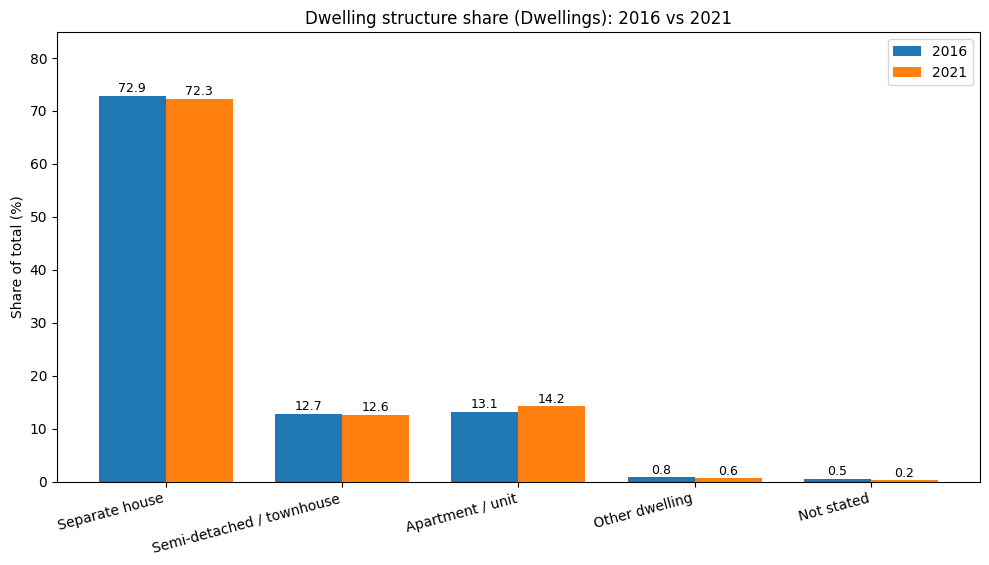

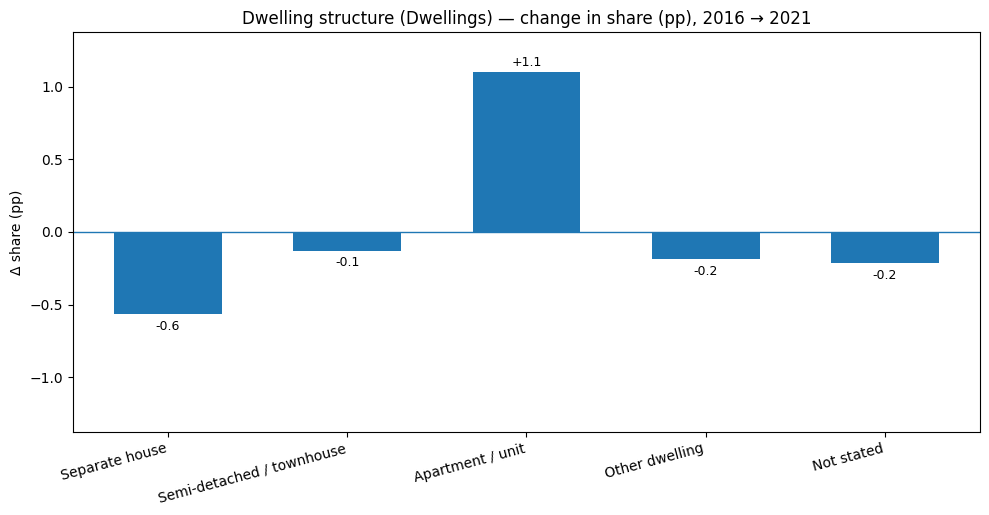

In [10]:
# build and plot dwelling visuals
dw_merge = visualise_dwelling(dwellings_and_persons_2016, dwellings_and_persons_2021)

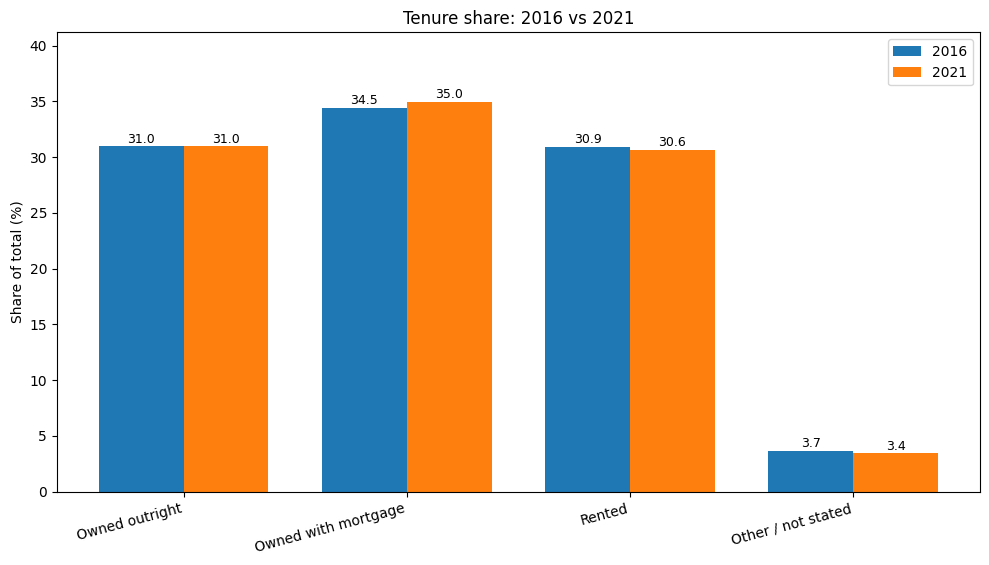

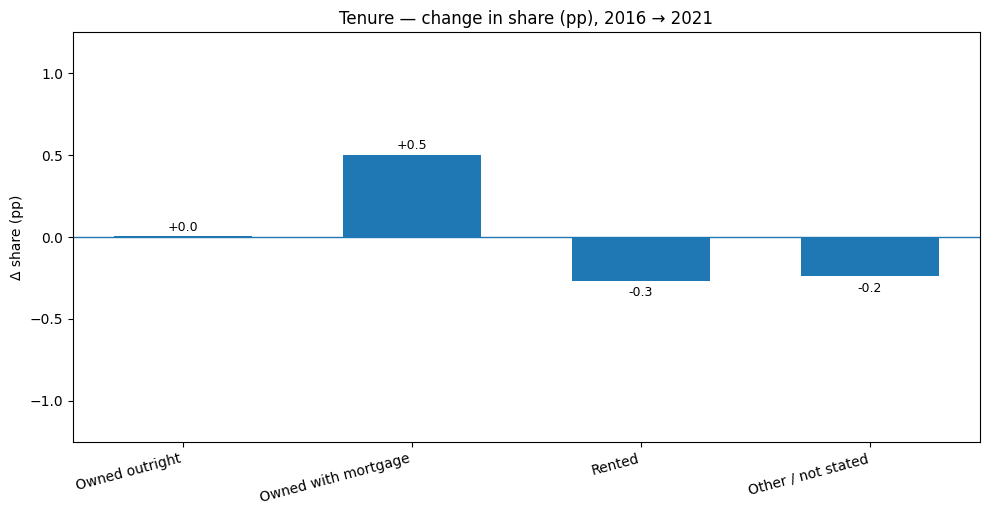

In [11]:
# build and plot tenure visuals
ten_merge = visualise_tenure(tenure_2016, tenure_2021)

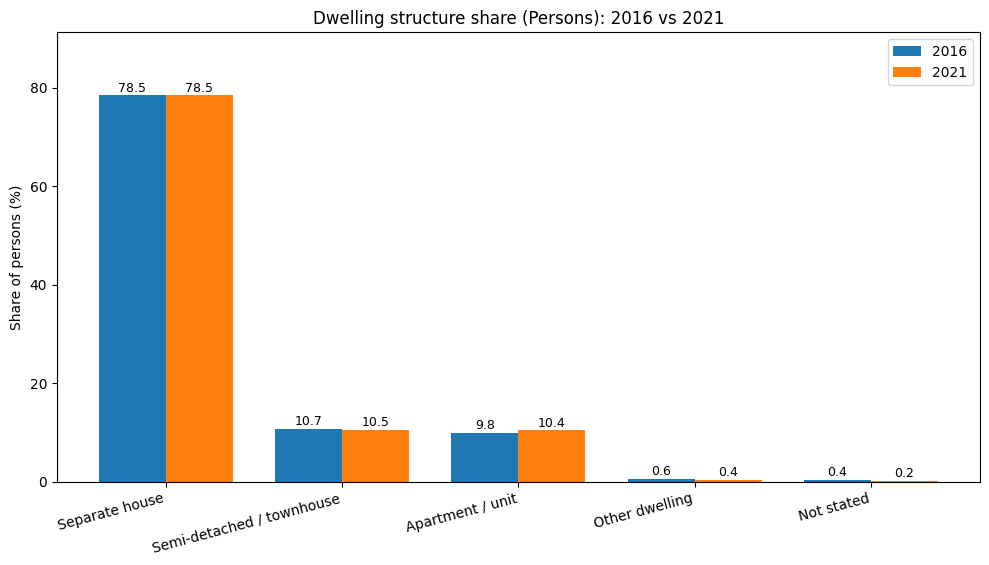

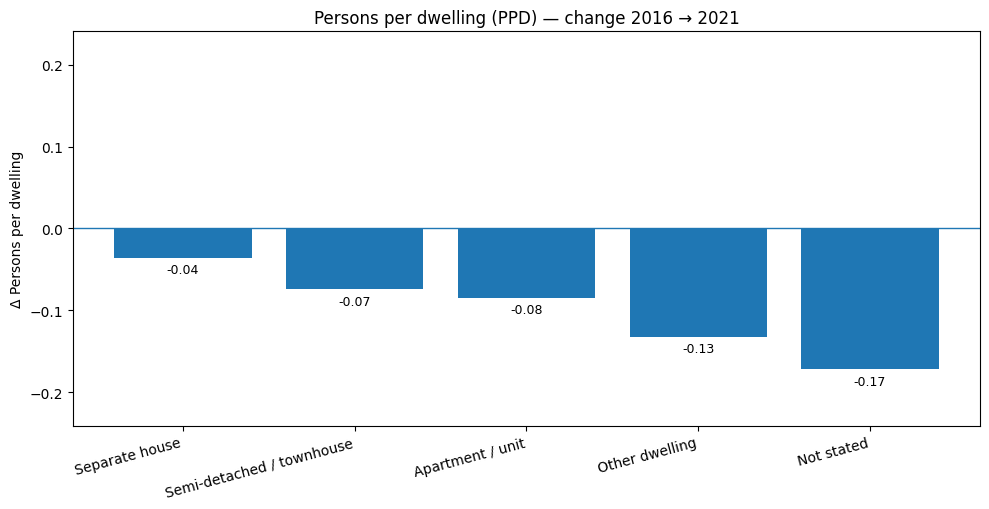

In [12]:
# persons share + Persons Per Dwelling
m_persons = visualise_dwelling_persons(dwellings_and_persons_2016, dwellings_and_persons_2021)

In [13]:
# textual summary
print_change_summary(dw_merge, ten_merge, persons_merge=m_persons)

Dwelling structure (shares based on DWELLINGS):
 - Separate house: 72.9% → 72.3% (-0.6 pp)
 - Semi-detached / townhouse: 12.7% → 12.6% (-0.1 pp)
 - Apartment / unit: 13.1% → 14.2% (+1.1 pp)
 - Other dwelling: 0.8% → 0.6% (-0.2 pp)
 - Not stated: 0.5% → 0.2% (-0.2 pp)

Tenure:
 - Owned outright: 31.0% → 31.0% (+0.0 pp)
 - Owned with mortgage: 34.5% → 35.0% (+0.5 pp)
 - Rented: 30.9% → 30.6% (-0.3 pp)
 - Other / not stated: 3.7% → 3.4% (-0.2 pp)

Population within occupied private dwellings (OPDs):
 - Persons: 21,499,917 → 23,567,772 (+9.6%)
 - Dwellings: 8,286,077 → 9,275,217 (+11.9%)
 - Persons grew slower than occupied dwellings

Persons share by dwelling structure:
 - Separate house: 78.5% → 78.5% (+0.0 pp)
 - Semi-detached / townhouse: 10.7% → 10.5% (-0.3 pp)
 - Apartment / unit: 9.8% → 10.4% (+0.6 pp)
 - Other dwelling: 0.6% → 0.4% (-0.2 pp)
 - Not stated: 0.4% → 0.2% (-0.2 pp)

Persons per dwelling (PPD):
 - Separate house: 2.79 → 2.76 (-0.04)
 - Semi-detached / townhouse: 2.19 → 

## 6. Conclusion: Changes in Housing Tenure & Structure (2016 → 2021) and What They Imply

This section summarises how Australia’s housing landscape shifted between the 2016 and 2021 Census years. We look at the data from three different angles: **dwelling structure (the housing stock)**, **tenure (affordability and ownership)**, and the **population perspective (where people live and how many per dwelling)**. Together these give a clearer picture of both supply and demand dynamics in housing.

### Dwelling Structure (Urbanisation)

* **Apartments/units:** 13.1% → 14.2% (**+1.1 pp**)
* **Semi-detached/townhouses:** 12.7% → 12.6% (**-0.1 pp**)
* **Separate houses:** 72.9% → 72.3% (**-0.6 pp**)

The story here is one of **increasing urban densification**. Australia is slowly shifting away from detached housing as a share of total occupied private dwellings, with apartments gaining ground. The rise in apartment share (+1.1 pp) and the corresponding decline in separate houses (–0.6 pp) suggest ongoing infill development and higher-density supply in urban areas.

### Tenure (Affordability)

* **Renting:** 30.9% → 30.6% (**-0.3 pp**)
* **Owned with mortgage:** 34.5% → 35.0% (**+0.5 pp**)
* **Owned outright:** 31.0% → 31.0% (**+0.0 pp**)

Tenure patterns appear **stable overall**. Renting remained roughly unchanged, while ownership with a mortgage rose slightly. The fact that the “owned outright” share held steady suggests that older households who have finished paying down their loans are offsetting pressures from younger households struggling to buy. Taken together, these movements point more to **ongoing affordability challenges** than to any major change in the balance of renting vs ownership.

### Population Perspective (Occupancy & Household Size)

* **Persons in occupied private dwellings (OPDs):** 21.5m → 23.6m (**+9.6% growth**)
* **Occupied private dwellings:** 8.29m → 9.28m (**+11.9% growth**)

Overall, the number of dwellings grew **faster** than the population living in them. This means Australia is adding homes at a slightly higher rate than population growth, which is reflected in the national average household size:

* **Average persons per occupied dwelling:** 2.59 → 2.54 (**–0.05**)

#### By Dwelling Structure

* **Separate house:** Persons share 78.5% → 78.5% (**+0.0 pp**). PPD: 2.79 → 2.76 (**–0.04**).
* **Semi-detached/townhouse:** Persons share 10.7% → 10.5% (**–0.3 pp**). PPD: 2.19 → 2.11 (**–0.07**).
* **Apartment/unit:** Persons share 9.8% → 10.4% (**+0.6 pp**). PPD: 1.94 → 1.86 (**–0.08**).
* **Other dwelling:** Persons share 0.6% → 0.4% (**–0.2 pp**). PPD: 1.88 → 1.75 (**–0.13**).
* **Not stated:** Persons share 0.4% → 0.2% (**–0.2 pp**). PPD: 2.15 → 1.98 (**–0.17**).

From the **people’s perspective**, the biggest story is that **apartments are housing a greater share of the population** (+0.6 pp). Even though average household sizes (PPD) declined slightly across all dwelling types, the rise in the apartment person-share confirms the densification trend we saw on the stock side.





## 7. Limitations, Assumptions, and Future Work

### Limitations

* **Occupied dwellings only:** The analysis is based on *occupied private dwellings (OPDs)*, which means unoccupied stock (vacant houses, investment properties, holiday homes) is not captured. This could understate the true supply picture, especially in high-vacancy areas.
* **National-level view:** All results are aggregated to the Australia-wide level. Regional differences (e.g., Sydney vs Perth vs regional towns) are masked, even though these places have very different housing dynamics.
* **Household types not considered:** The data does not break down by household type (e.g., families, lone-person households, group households). These differences could help explain why average household sizes fell.
* **No direct affordability measure:** Tenure is used as a proxy for affordability (e.g., more renting might indicate housing stress), but it doesn’t capture actual costs, incomes, or mortgage stress.

### Assumptions

* **Category stability:** I assumed that tenure and dwelling structure categories in 2016 and 2021 are consistent and directly comparable.
* **Proportion-based comparisons:** Shares (proportions) are treated as the most reliable basis for year-to-year comparison, given that Australia’s population grew between 2016 and 2021. This assumes relative change tells a clearer story than absolute counts alone.
* **Uniform PPD interpretation:** Persons per dwelling (PPD) is interpreted as a crowding/occupancy measure, even though cultural and household norms (e.g., multigenerational households) may affect these values.

### Future Work

* **Regional analysis:** Breaking results down by capital city and regional areas would highlight where densification is strongest and where detached houses are still dominant.
* **Linking with affordability data:** Combining Census tenure data with external data on rents, mortgage repayments, and household income would give a sharper picture of affordability pressures.
* **Demographic cross-tabs:** Looking at tenure and dwelling type by age group, household type, or migration background could show *who* is driving changes in renting, apartment living, or downsizing.
* **Time-series extension:** Extending the comparison back to earlier Censuses (e.g., 2006, 2011) would allow me to see whether trends since 2016 are part of a longer trajectory or just short-term shifts.

## 8. Appendix – Reproducibility Notes

This appendix explains how the data was obtained, processed, and analysed so that the results in this report can be fully reproduced.

### Data Source

* **Provider:** Australian Bureau of Statistics (ABS).
* **Census years:** 2016 and 2021.
* **DataPack type:** *General Community Profile (GCP)*.
* **Geography:** *Australia – total*.
* **Tables used:**

  * **Tenure:** G33 (2016) and G37 (2021).
  * **Dwelling Structure & Persons:** G32 (2016) and G36 (2021).
* **Access path:** ABS website → *Census → DataPacks → General Community Profile → CSV download*. (https://www.abs.gov.au/census/find-census-data/datapacks)

### File Preparation

* Each DataPack is a ZIP file containing multiple CSVs and metadata.
* The relevant tables (G32/G36 and G33/G37) were extracted into a local project directory.
* File paths in the notebook point directly to these CSVs (e.g., `path_2016_G32`, `path_2021_G36`).

### Software Environment

* **Platform:** Google Colab (as required by the assignment).
* **Python version:** 3.x (default in Colab).
* **Libraries used:**

  * `pandas` (data loading and wrangling)
  * `numpy` (numeric operations)
  * `matplotlib` (visualisation)
* No additional packages were installed beyond the Colab defaults.

### Code Structure

1. **Helper functions**: Safe loading, cleaning, and utility functions (`load_table`, `safe_num`, `extract_tenure`, `extract_dwelling_structure_and_persons`, etc.).
2. **Loading stage**: Each Census table is read into a tidy DataFrame, with a `Year` column added. Proportions are calculated within-year.
3. **Merging stage**: 2016 and 2021 tables are aligned on categories (e.g., `Tenure`, `DwellingType`) using `left_join_categories`.
4. **Visualisation stage**: Reusable plotting functions (`plot_grouped_share`, `plot_delta_bars`, etc.) generate side-by-side and delta charts.
5. **Narrative stage**: Summariser functions (`print_change_summary`, `summarise_population_shifts`) print human-readable interpretations.

### Assumptions for Replication

* The CSVs used are the **official ABS DataPacks** with no manual editing of raw data.
* Category labels between 2016 and 2021 were standardised in the code (e.g., merging “Other” and “Not stated”).
* Calculations are based only on **occupied private dwellings** (OPDs).

### How to Reproduce

1. Download the **2016** and **2021 GCP DataPacks** (Australia, CSV).
2. Extract and place the relevant tables (G32/G33 for 2016, G36/G37 for 2021) into your project directory.
3. Update the file path variables (`path_2016_G32`, `path_2021_G36`, etc.) in the notebook.
4. Run the notebook from top to bottom in Google Colab.
5. Outputs (tables, plots, and summaries) should match the results shown in this report.